In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import pandas as pd

In [18]:
def calc_price(theta1, theta2, mu1, mu2, cost, listprice):
    """compute each insurer's price (assumes interior solution)"""
    p1 = (2.*theta1*mu1+theta2*mu2)/3. + cost
    p2 = (2.*theta2*mu2+theta1*mu1)/3. + cost
    #return np.clip(p1,0,listprice), np.clip(p2,0,listprice)
    return np.max(p1,0), np.max(p2,0)
  
    
def calc_t(theta1, theta2, mu1, mu2, cost, listprice):
    """compute the proportion of people choosing each insurer
    assumes interior solution"""
    p1, p2 = calc_price(theta1, theta2, mu1, mu2, cost, listprice)
    t_hat = .5 + (p2 - p1)/(2.*cost)
    return t_hat


def calc_eq(theta1, theta2, mu1, mu2, cost, listprice):
    """compute eq profit for each firm and market shares
    Go through each KKT to ensure that we see if the market 
    is covered or not... """

    #interior solution
    p1, p2 = calc_price(theta1, theta2, mu1, mu2, cost, listprice)
    t1 = calc_t(theta1, theta2, mu1, mu2, cost, listprice)
    #check to see if interior makes sense?
        
    #print('eq:',t1,(listprice - p1)/cost, 'price:', p1 ,p2)
    if t1 > (listprice - p1)/cost or t1 < 0: 
        t1 = -1
    
    #solve the local monopoly case
    p0 = (listprice + mu1*theta1)/2
    t0 = (listprice - mu1*theta1)/(2*cost)
    #does monopoly make sense?
    t0_firm2 = (listprice - mu2*theta2)/(2*cost)  
            
    #print('local monop',t0,p0)
    if t0_firm2 + t0 > 1:
        t0 = -1
    
    #find the max profits
    profits =  [t0*(p0-theta1*mu1),t1*(p1-theta1*mu1), 0]
    ind = np.argmax(profits)
    return [t0,t1,0], profits, [p0,p1,0], ind


def calc_profits(theta1,theta2,mu1,mu2,cost, listprice):
    t1, profits1, prices1, index1 = calc_eq(theta1, theta2, mu1, mu2, cost, listprice)
    t2, profits2, prices2, index2 = calc_eq(theta2, theta1, mu2, mu1, cost, listprice)
    hosp_profit = t1[index1]*theta1*mu1 +  t2[index2]*theta2*mu2
    print(listprice,cost, theta1, theta2, mu1, t1[index1], t2[index2], prices1[index1], prices2[index2] ,profits1[index1], profits2[index2], hosp_profit, (index1==0 or index2==0 or index2 ==2 or index1==2),(index1==1 or index2==1 or index2 ==2 or index1==2))
    return hosp_profit, profits1[index1], profits2[index2]

    
def outside_simlt(cost,listprice):
    """outside option in simult case
    assuming listprice high enough"""
    if cost/listprice  > 3/8:
        return 3*listprice**2/(32*cost)
    else:
        return (listprice -cost)/2
    

#arbitrary outside option...
def nash_in_nash(theta1, theta2, mu1, mu2, cost, listprice, outside):
    hosp_profit, profits1, profits2 = calc_profits(theta1, theta2, mu1, mu2, cost, listprice)
    obj = -1*(max(hosp_profit-outside,0)*profits1)**.5
    print(outside,-1*obj)
    return obj


COST = 3
LIST = 7
print(nash_in_nash(COST,COST, .5, .5, COST,LIST, outside_simlt(COST,LIST)))
print('----')
print(nash_in_nash(4.5,4.5,.5, .5, COST,LIST, outside_simlt(COST,LIST)))
print('----')
print(nash_in_nash(LIST-1,LIST-1, .5, .5, COST, LIST, outside_simlt(COST,LIST)))

7 3 3 3 0.5 0.5 0.5 4.5 4.5 1.5 1.5 1.5 False True
1.53125 0.0
-0.0
----
7 3 4.5 4.5 0.5 0.5 0.5 5.25 5.25 1.5 1.5 2.25 False True
1.53125 1.0383279828647594
-1.0383279828647594
----
7 3 6 6 0.5 0 0 0 0 0 0 0.0 True True
1.53125 0.0
-0.0


5 3 1.5 5 0.5 0 0 0 0 0 0 0.0 True True
0.78125 0.0
5 3 2.033333333333333 5 0.5 0 0 0 0 0 0 0.0 True True
0.78125 0.0
5 3 2.5666666666666664 5 0.5 0 0 0 0 0 0 0.0 True True
0.78125 0.0
5 3 3.1 5 0.5 0.5750000000000001 0.4166666666666667 3.275 3.75 0.9918750000000001 0.5208333333333334 1.9329166666666668 True False
0.78125 1.0687887419878637


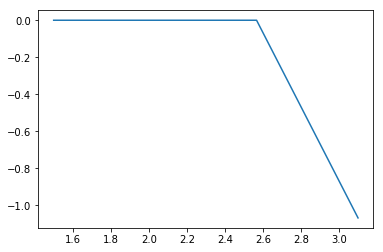

In [19]:
COST = 3
LIST = 5
MU = .5

plt.plot([i for i in np.linspace(1.5,3.1,num=4)], 
         [nash_in_nash(i, LIST, MU, MU, COST,LIST, outside_simlt(COST,LIST)) 
                                                          for i in np.linspace(1.5,3.1,num=4)])

7 3 1.5 7 0.5 0.6527777777777778 0.3472222222222222 4.666666666666667 5.583333333333334 2.5567129629629632 0.7233796296296298 1.7048611111111112 False True
1.53125 0.6662385295764433
7 3 2.033333333333333 7 0.5 0.6379629629629631 0.36203703703703694 4.844444444444444 5.6722222222222225 2.441980452674897 0.7864248971193415 1.915725308641975 False True
1.53125 0.9689588165860564
7 3 2.5666666666666664 7 0.5 0.6231481481481481 0.3768518518518518 5.022222222222222 5.761111111111111 2.329881687242798 0.8521039094650205 2.1186882716049382 False True
1.53125 1.1698981457365878
7 3 3.1 7 0.5 0 0 0 0 0 0 0.0 True True
1.53125 0.0


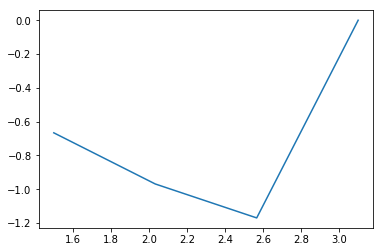

In [14]:
COST = 3
LIST = 7
MU = .5

plt.plot([i for i in np.linspace(1.5,3.1,num=4)], 
         [nash_in_nash(i, LIST, MU, MU, COST,LIST, outside_simlt(COST,LIST)) 
                                                          for i in np.linspace(1.5,3.1,num=4)])

12 3 1.5 12 0.5 0.7916666666666667 0.20833333333333331 5.5 7.25 3.760416666666667 0.26041666666666663 1.84375 False True
4.5 0.0
12 3 2.033333333333333 12 0.5 0.7768518518518519 0.2231481481481481 5.677777777777777 7.338888888888889 3.6209927983539094 0.2987705761316871 2.128688271604938 False True
4.5 0.0
12 3 2.5666666666666664 12 0.5 0.7620370370370371 0.237962962962963 5.855555555555556 7.427777777777778 3.4842026748971198 0.339758230452675 2.4057253086419754 False True
4.5 0.0
12 3 3.1 12 0.5 0.7472222222222222 0.25277777777777777 6.033333333333333 7.516666666666667 3.3500462962962962 0.3833796296296296 2.6748611111111114 False True
4.5 0.0


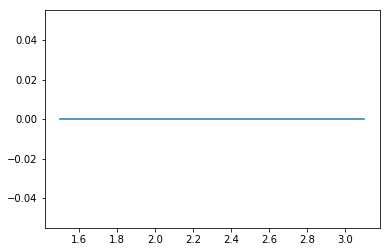

In [15]:
COST = 3
LIST = 12
MU = .5

plt.plot([i for i in np.linspace(1.5,3.1,num=4)], 
         [nash_in_nash(i, LIST, MU, MU, COST,LIST, outside_simlt(COST,LIST)) 
                                                          for i in np.linspace(1.5,3.1,num=4)])

In [14]:
def bargain_helper(theta1, theta2, mu1, mu2, cost, listprice):
    """solve each firm 1s optimization holding theta 2 fixed"""
    outside = outside_simlt(cost,listprice)
    result = minimize(nash_in_nash, theta1, args=(theta2, mu1, mu2, cost, listprice, outside),
                      method='Nelder-Mead', options={'disp': False})
    return result.x

COST = 3
LIST = 7
print(bargain_helper(4.5, 4.5, .5, .5, COST,LIST))

1 1
1 1
1 1
1 1
2 2
1 1
1 1
2 2
2 2
1 1
2 2
1 1
1 1
2 2
2 2
1 1
1 1
2 2
2 2
1 1
1 1
2 2
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
1 1
2 2
2 2
1 1
1 1
2 2
2 2
1 1
1 1
2 2
2 2
1 1
2 2
1 1
[5.49997559]


In [17]:
def simult_bargain(theta1, theta2, mu1, mu2, cost, listprice):
    """solve the bargaining problems seperately and iterate for a solution"""       
    
    #loop variables
    diff =  theta1

    maxiter = 10
    while maxiter >=0 and diff > 10e-7:
        #seems as though there is a contraction mapping here, need to think more about why
        theta1 = bargain_helper(theta1, theta2, mu1, mu2, cost, listprice)
        theta2 = bargain_helper(theta2, theta1, mu2, mu1, cost,  listprice)
        
        #update loop variables
        diff = np.abs(np.max(theta1 - theta2))
        maxiter = maxiter-1
        
    return theta1, theta2

COST = 3
LIST = 7
print(simult_bargain(4.5,4.5,.5,.5,COST,LIST))

1 1
1 1
1 1
1 1
2 2
1 1
1 1
2 2
2 2
1 1
2 2
1 1
1 1
2 2
2 2
1 1
1 1
2 2
2 2
1 1
1 1
2 2
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
1 1
2 2
2 2
1 1
1 1
2 2
2 2
1 1
1 1
2 2
2 2
1 1
2 2
1 1
1 1
2 2
1 1
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
1 1
2 2
1 1
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
1 1
2 2
1 1
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
1 1
2 2
1 1
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
1 1
2 2
1 1
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
1 1
2 2
1 1
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
1 1
2 2
1 1
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
1 1
2 2
1 1
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1
2 2
1 1


In [25]:
def outside_seq(theta1,mu1,cost,listprice):
    """go through kkt to find a solution"""
    #three solutions to firms optimization problem
    p0, p1, p2 =  listprice - cost, (listprice + (mu1*theta1))/2, listprice
    t0,t1,t2 = 1, (listprice - mu1*theta1)/(2*cost) , 0
    #double check t1 is a valid solution
    if t1 > 1 or t1 < 0:
        t1 = -1
    #find the max
    ind = np.argmax([p0*t0, p1*t1, p2*t2])
    print([t0,t1,t2], ind)
    return mu1*theta1*([t0,t1,t2][ind])


def outside_seq(theta1,mu1,cost,listprice):
    """assume that we amp up list price high enough
    for a corner solution"""
    return mu1*theta1


def bargain_helper_seq(theta1, mu1, mu2, cost, listprice):
    """solve each firm 1s optimization holding theta 2 fixed"""
    outside = outside_seq(theta1,mu1,cost,listprice)
    result = minimize(nash_in_nash, 10., args=(theta1, mu2, mu1, cost, listprice, outside),
                      method='Nelder-Mead', options={'disp': False})
    return result.x


def seq_obj(theta1, mu1, mu2, cost, listprice):
    """ theta1 is a guess for the first stage """
    
    theta2 = bargain_helper_seq(theta1, mu2, mu1, cost, listprice)
    outside1 = outside_simlt(cost,listprice)

    return nash_in_nash(theta1, theta2, mu1, mu2, cost, listprice, outside1)


COST = 3
LIST = 10
plt.plot([i for i in np.linspace(COST+3,LIST +3,num=10)],  
         [seq_obj(i, .5, .5, COST , LIST) for i in np.linspace(COST+3,LIST +3,num=10)])

#for i in np.linspace(COST,LIST,num=10):
#    print('---')
#    print(i)
#    print( calc_eq(i, bargain_helper_seq(i, .5, .5, COST,LIST),  .5, .5, COST,LIST))
#    print(calc_profits(i,  bargain_helper_seq(i, .5, .5, COST,LIST),  .5, .5, COST,LIST))

TypeError: outside_simlt() takes 2 positional arguments but 3 were given

In [16]:
def seq_bargain(theta1, mu1, mu2, cost, listprice):
    """solve the bargaining problems seperately,
    then solve for the solution"""   
    #only compute no deal 1x for initial
    result = minimize(seq_obj, theta1, args=(mu1, mu2, cost, listprice),
                      method='Nelder-Mead', options={'disp': False})
    theta1 = result.x
    theta2 = bargain_helper(theta1, theta1, mu2, mu1, cost, listprice)
    return theta1, theta2


print(seq_bargain(5,.5,.5,3,11))

(array([8.53173828]), array([5.670242]))


In [26]:
def make_table(arg, steps, params):
    min_arg, max_arg, no_step = steps
    
    cols = ['eq_type','listprice','distance_cost','mc1','mc2','profit1','profit2','hosp_profit','share1','share2']
    
    indep_var = np.linspace(min_arg, max_arg, no_step)
    results = []
    
    for var in indep_var:
        param_copy = list(params)
        param_copy[arg] = var
        mu1,mu2,cost,listprice = param_copy
        for eq_type in ['Simultaneous', 'Sequential']:
            
            mc1,mc2 = 15, 15
            
            if eq_type == 'Simultaneous':
                mc1,mc2 = simult_bargain(mc1, mc2, mu1, mu2, cost, listprice)
            else:
                mc1,mc2 = seq_bargain(mc1, mu1, mu2, cost, listprice)
            mc1, mc2 = mc1[0],mc2[0]
            
            share1, profit1, prices1, index1 = calc_eq(mc1, mc2, mu1, mu2, cost, listprice)
            share2, profit2, prices2, index2 = calc_eq(mc2, mc1, mu1, mu2, cost, listprice)
            
            share1, profit1, prices1 = share1[index1], profit1[index1], prices1[index1]
            share2, profit2, prices2 = share2[index2], profit2[index2], prices2[index2]
            
            hosp_prof = share1*mc1*mu1 + share2*mc2*mu2
            
            results.append([eq_type,listprice,cost,mc1,mc2,profit1,profit2,hosp_prof, share1,share2])
            
        
    return pd.DataFrame(data=results, columns=cols)
    

make_table(2,(3,6,5), (.5,.5,3,20))

,eq_type,listprice,distance_cost,mc1,mc2,profit1,profit2,hosp_profit,share1,share2
0,Simultaneous,20,3.00,4.500016,4.500020,1.500001,1.499999,2.250009,0.500000,0.500000
1,Sequential,20,3.00,8.531067,5.670004,1.061053,2.014740,3.436578,0.420526,0.579474
2,Simultaneous,20,3.75,5.625035,5.625036,1.875000,1.875000,2.812518,0.500000,0.500000
3,Sequential,20,3.75,10.687500,7.096124,1.324208,2.521333,4.302595,0.420192,0.579808
4,Simultaneous,20,4.50,6.749993,6.750012,2.250003,2.249997,3.375001,0.500000,0.500000
5,Sequential,20,4.50,12.843750,8.522154,1.587377,3.027909,5.168548,0.419970,0.580030
6,Simultaneous,20,5.25,7.874991,7.875030,2.625007,2.624993,3.937505,0.500001,0.499999
7,Sequential,20,5.25,14.929504,9.922598,1.856836,3.525805,6.014065,0.420525,0.579475
8,Simultaneous,20,6.00,8.999980,9.000004,3.000004,2.999996,4.499996,0.500000,0.500000
9,Sequential,20,6.00,17.115051,11.359248,2.117388,4.035989,6.888511,0.420058,0.579942


In [27]:
table1 = make_table(2,(3,6,5), (.5,.5,3,20))
table2 = make_table(3,(9,14,5), (.5,.5,3,10))

table1.to_csv('distance_cost_table.csv',float_format='%.3f',index=False)
table2.to_csv('listprice_table.csv',float_format='%.3f',index=False)